In [38]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
result_columns = ['imp', 'dataset', 'metric', 'value',
                  'num_samples', 'num_features', 'uncorr_frac',
                  'add_frac', 'remove_frac', 'seed']
results_df = None
results_dir = './results/network_noise_results'
p_uncorr_frac = 0.5
p_dataset = 'train'

def parse_pickle(fname, n, p, uncorr_frac, add_frac,
                 remove_frac, seed, network=True):
    results = []
    with open(fname, 'rb') as f:
        r_map = pkl.load(f)
    for k, v in r_map.items():
        imp, ds, metric = k.split('_')
        results.append([imp, ds, metric, v[0], n, p,
                        uncorr_frac, add_frac, remove_frac, seed])
    return pd.DataFrame(results, columns=result_columns)
    
# read results from output directory
for fname in os.listdir(results_dir):
    if os.path.isdir(fname): continue
    if 'cv_results' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    uncorr_frac = float(f_sp[4].replace('u', ''))
    add_frac = float(f_sp[5].replace('a', ''))
    remove_frac = float(f_sp[6].replace('r', ''))
    seed = int(f_sp[7].replace('s', ''))
    df = parse_pickle(os.path.join(results_dir, fname),
                      n, p, uncorr_frac, add_frac, remove_frac, seed)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
        
results_df.head(n=10)

,imp,dataset,metric,value,num_samples,num_features,uncorr_frac,add_frac,remove_frac,seed
0,torch,train,rmse,17.040186,100,1000,0.0,0.09,0.0,3
1,torch,train,r2,0.730171,100,1000,0.0,0.09,0.0,3
2,torch,test,rmse,32.173486,100,1000,0.0,0.09,0.0,3
3,torch,test,r2,0.077427,100,1000,0.0,0.09,0.0,3
4,sklearn,train,rmse,0.004817,100,1000,0.0,0.09,0.0,3
5,sklearn,train,r2,1.000000,100,1000,0.0,0.09,0.0,3
6,sklearn,test,rmse,30.424694,100,1000,0.0,0.09,0.0,3
7,sklearn,test,r2,0.174995,100,1000,0.0,0.09,0.0,3
0,torch,train,rmse,0.348297,100,10,0.5,0.30,0.2,3
1,torch,train,r2,0.973945,100,10,0.5,0.30,0.2,3


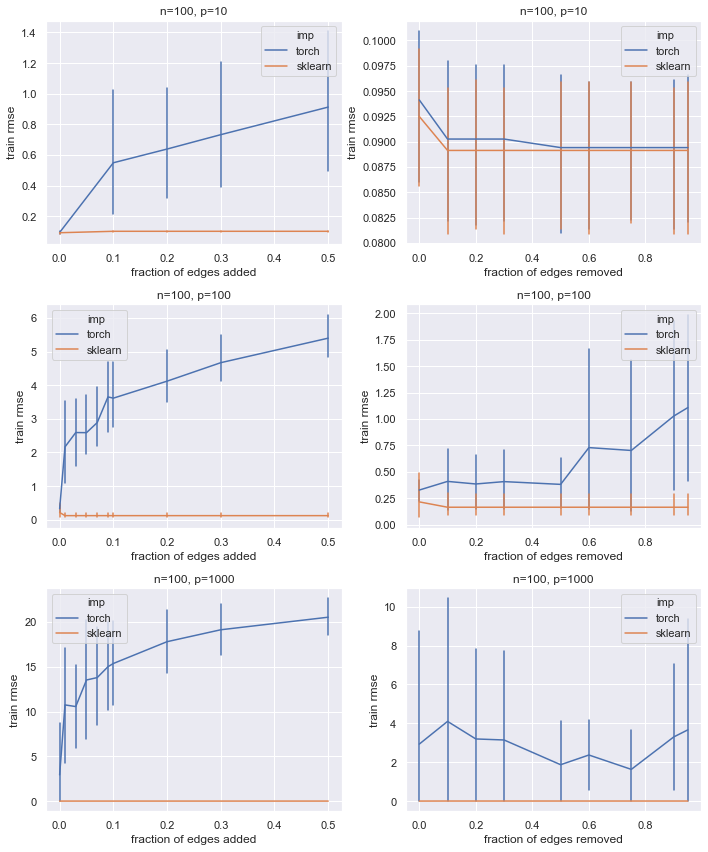

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

num_samples = 100
metric = 'rmse'
add_fracs = np.unique(results_df['add_frac'].values)
remove_fracs = np.unique(results_df['remove_frac'].values)

sns.set()
fig, axarr = plt.subplots(3, 2)
fig.set_figwidth(10)
fig.set_figheight(12)

for i, num_feats in enumerate((10, 100, 1000)):
    # line plot over add_fracs with remove_frac = 0
    ax1 = axarr[i, 0]
    filter_df = results_df[(results_df['num_samples'] == num_samples) &
                           (results_df['num_features'] == num_feats) &
                           (results_df['dataset'] == p_dataset) &
                           (results_df['uncorr_frac'] == p_uncorr_frac) &
                           (results_df['remove_frac'] == 0.0) &
                           (results_df['metric'] == metric)]
    sns.lineplot(data=filter_df, x='add_frac', y='value',
                 hue='imp', err_style='bars', ax=ax1)
    ax1.set_title('n={}, p={}'.format(num_samples, num_feats))
    ax1.set_xlabel('fraction of edges added')
    ax1.set_ylabel('{} {}'.format(p_dataset, metric))
    # line plot over remove_fracs with add_frac = 0
    ax2 = axarr[i, 1]
    filter_df = results_df[(results_df['num_samples'] == num_samples) &
                           (results_df['num_features'] == num_feats) &
                           (results_df['dataset'] == p_dataset) &
                           (results_df['uncorr_frac'] == p_uncorr_frac) &
                           (results_df['add_frac'] == 0.0) &
                           (results_df['metric'] == metric)]
    sns.lineplot(data=filter_df, x='remove_frac', y='value',
                 hue='imp', err_style='bars', ax=ax2)
    ax2.set_title('n={}, p={}'.format(num_samples, num_feats))
    ax2.set_xlabel('fraction of edges removed')
    ax2.set_ylabel('{} {}'.format(p_dataset, metric))
    
plt.tight_layout()
    